# Imports


In [1]:
import pandas as pd
import numpy as np
import os
from Bio import SeqIO
from Bio.SeqUtils.ProtParam import ProteinAnalysis
from Bio.Alphabet.IUPAC import ExtendedIUPACProtein
from Bio.Alphabet import generic_dna
from Bio.Alphabet import IUPAC
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.cluster import KMeans
from itertools import cycle
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
import matplotlib.pyplot as plt
import itertools


# Loading data

In [2]:
ROOT_DIR = os.getcwd()
# Directory of images to run detection on
DATA_DIR = os.path.join(ROOT_DIR, "Data")

### Training data

In [3]:
file_names = next(os.walk(DATA_DIR))[2]
print(file_names)
class_names = []

alphabet = ExtendedIUPACProtein()

cols = ['seq', 'seq_length', "molecular_weight", 'isoelectric_point', 'aromaticity', 'instability']
ids = []
sequences = []
location = []
location_name = []
lengths = []
mol_weight = []
aromaticity = []
instability = []
gravy = []
isoelectric_point = []
aa_percents = []
first_50_percents = []
last_50_percents = []
structure = []
duds = 0
dud_location = []

for file in file_names:
    if file == "test.rtf":
        pass
    else:
        class_names.append(str(file)[:-4])
        for seq_record in SeqIO.parse(os.path.join(DATA_DIR, file), "fasta", alphabet=ExtendedIUPACProtein()):

            clean_sequence = str(seq_record.seq).translate({ord(c): None for c in '\!@#$/{}XU'})
            sequences.append(clean_sequence)


            lengths.append(len(clean_sequence))

            location_name.append(str(file)[:-4])

            if file == 'Nuclear.rtf':
                location.append(0)
            elif file == "Secreted.rtf":
                location.append(1)
            elif file == 'Mytochodrial.rtf':
                location.append(2)
            elif file == 'Cytosolic.rtf':
                location.append(3)
            else:
                print("Wrong location/file name!")

            analysed_seq = ProteinAnalysis(clean_sequence)
            mol_weight.append(analysed_seq.molecular_weight())
            aromaticity.append(analysed_seq.aromaticity())
            instability.append(analysed_seq.instability_index())
#             gravy.append(analysed_seq.gravy())
            isoelectric_point.append(analysed_seq.isoelectric_point())

            aa_percents.append(analysed_seq.get_amino_acids_percent())

            first_50_seq = ProteinAnalysis(clean_sequence[0:49])
            first_50_percents.append(first_50_seq.get_amino_acids_percent())

            last_50_seq = ProteinAnalysis(clean_sequence[-50:])
            last_50_percents.append(last_50_seq.get_amino_acids_percent())

            structure.append(analysed_seq.secondary_structure_fraction())

['test.rtf', 'Nuclear.rtf', 'Secreted.rtf', 'Mytochodrial.rtf', 'Cytosolic.rtf']


In [4]:
aa_percents_DF = pd.DataFrame.from_dict(aa_percents)
first_50_df = pd.DataFrame.from_dict(first_50_percents)
last_50_df = pd.DataFrame.from_dict(last_50_percents)
structure_df = pd.DataFrame(structure)
parsed_df = pd.DataFrame(list(zip(sequences, lengths, mol_weight, isoelectric_point, aromaticity, instability)), columns=cols)            

parsed_df = pd.concat([parsed_df, first_50_df, aa_percents_DF, last_50_df, structure_df], axis=1)
labels_df = pd.DataFrame(location)

In [5]:
print("Number of proteins rejected: {}".format(duds))
unique, counts = np.unique(location, return_counts=True)
print("Class proportions analysed: {}".format(dict(zip(unique, counts))))
dud_unique, dud_counts = np.unique(dud_location, return_counts=True)
print("Samples rejected: {}".format(dict(zip(dud_unique, dud_counts))))

Number of proteins rejected: 0
Class proportions analysed: {0: 3314, 1: 491, 2: 1299, 3: 3004}
Samples rejected: {}


In [6]:
parsed_df.head()

,seq,seq_length,molecular_weight,isoelectric_point,aromaticity,instability,A,C,D,E,...,Q,R,S,T,V,W,Y,0,1,2
0,MCSLGLFPPPPPRGQVTLYEHNNELVTGSSYESPPPDFRGQWINLP...,546,59573.4321,7.260193,0.086081,43.727289,0.000000,0.020408,0.020408,0.061224,...,0.02,0.02,0.10,0.06,0.04,0.02,0.00,0.305861,0.302198,0.236264
1,MAGPQPLALQLEQLLNPRPSEADPEADPEEATAARVIDRFDEGEDG...,560,63132.1711,4.829895,0.060714,57.456982,0.142857,0.000000,0.122449,0.163265,...,0.02,0.08,0.06,0.06,0.02,0.00,0.02,0.232143,0.219643,0.301786
2,MNPQIRNPMERMYRDTFYDNFENEPILYGRSYTWLCYEVKIKRGRS...,382,45923.8104,5.740906,0.180628,33.354503,0.000000,0.020408,0.040816,0.081633,...,0.10,0.06,0.06,0.04,0.04,0.04,0.06,0.358639,0.178010,0.253927
3,MDKLVVNYYEYKHPIINKDLAIGAHGGKKFPTLGAWYDVINEYEFQ...,731,81751.5318,4.860535,0.046512,39.270999,0.061224,0.020408,0.061224,0.061224,...,0.08,0.02,0.06,0.04,0.02,0.00,0.02,0.212038,0.322845,0.184679
4,MVTRETKLTSEREVESSMAQARHNGGGGGENHPFTSLGRQSSIYSL...,442,47006.1865,9.080750,0.049774,42.974661,0.040816,0.000000,0.020408,0.102041,...,0.08,0.12,0.08,0.02,0.00,0.00,0.02,0.187783,0.373303,0.230769


# Get data in numpy array form for analysis
Now the data has been loaded into the dataframes, we can create the features and labels:

In [7]:
features_array = parsed_df.drop(columns='seq').values
labels_array = labels_df.values.ravel()

## Create train and validation split

In [8]:
X_train, X_val, y_train, y_val = train_test_split(features_array, labels_array, test_size=0.25, random_state=42)

In [9]:
unique_train, counts_train = np.unique(y_train, return_counts=True)
print("Class proportions in training set: {}".format(dict(zip(unique_train, counts_train))))
unique_val, counts_val = np.unique(y_val, return_counts=True)
print("Class proportions in validation set: {}".format(dict(zip(unique_val, counts_val))))

Class proportions in training set: {0: 2474, 1: 376, 2: 968, 3: 2263}
Class proportions in validation set: {0: 840, 1: 115, 2: 331, 3: 741}


# Create Models

In [10]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    cmap=plt.cm.Blues
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Logistic regression

In [11]:
logreg = LogisticRegression()

logreg.fit(X_train, y_train)

y_pred_log = logreg.predict(X_val)

## SVM

In [12]:
# Define Model
svc = svm.SVC(probability=True)

# Fit model
svc.fit(X_train, y_train)

# Make predictions on validation set
y_pred_SVM = svc.predict(X_val)

## Random forest

In [13]:
forest = RandomForestClassifier(n_estimators=50, oob_score=True, class_weight='balanced')

forest.fit(X_train, y_train)

y_pred_forest = forest.predict(X_val)

## Adaboost

In [14]:
attaboy = AdaBoostClassifier(base_estimator=forest, n_estimators = 150)
attaboy.fit(X_train, y_train)
y_pred_ada = attaboy.predict(X_val)

## Ensemble

In [15]:
eclf = VotingClassifier(estimators = [('LogReg', logreg), ("SVM", svc), ("Random Forest", forest), ('AdaBoost', attaboy)], voting='soft')
eclf.fit(X_train, y_train)
y_pred_eclf = eclf.predict(X_val)

/Users/daniel/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


# Model evaluation:

In [16]:
# Cross validate results? Set False for quick and dirty comparison of models.
cross_val = True
cv_k = 8

### Logistic Regression

Accuracy score for Logistic Regression: 0.4287123828317711
F1 score for Logistic Regression: 0.34260102577002044
[0.4242126  0.43405512 0.4137931  0.40078973 0.43280632 0.42391304
 0.42588933 0.42885375]
Accuracy: 0.42303912550519374 (+/- 0.020510350717654145)
Normalized confusion matrix


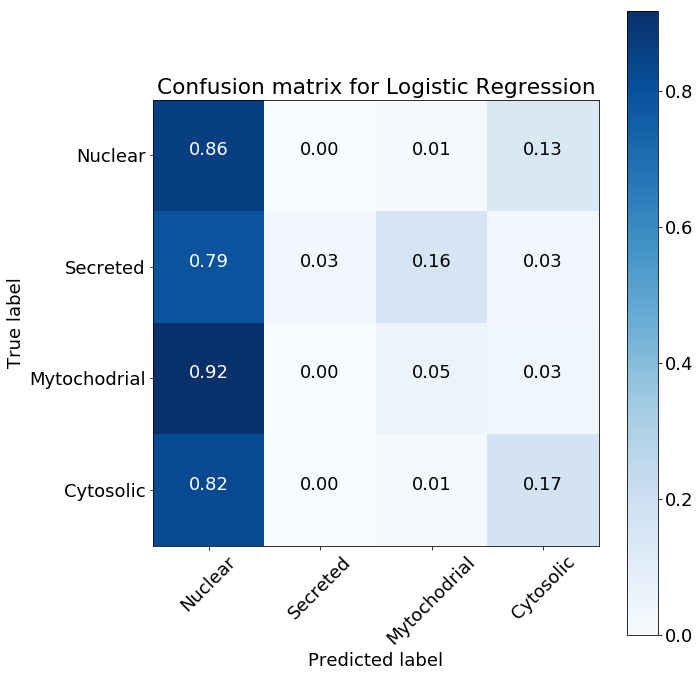

In [17]:
logreg_accuracy = accuracy_score(y_val, y_pred_log)
print("Accuracy score for Logistic Regression: {}".format(logreg_accuracy))
logreg_f1 = f1_score(y_val, y_pred_log, average='weighted')
print("F1 score for Logistic Regression: {}".format(logreg_f1))
# print("Confusion matrix for Logistic Regression: ")

if cross_val:
    LR_cv_scores = cross_val_score(logreg, features_array, labels_array, cv=cv_k)
    print(LR_cv_scores)

    print("Accuracy: {} (+/- {})".format(LR_cv_scores.mean(), (LR_cv_scores.std() * 2)))

logreg_cnf = confusion_matrix(y_val, y_pred_log)
plt.figure(figsize=(10,10))
plt.rc('font', size=18)
plot_confusion_matrix(logreg_cnf, classes=class_names, normalize=True,
                      title='Confusion matrix for Logistic Regression')
plt.show()

### SVM

In [18]:
SVM_accuracy = accuracy_score(y_val, y_pred_SVM)
print("Accuracy score for SVM: {}".format(SVM_accuracy))
SVM_f1 = f1_score(y_val, y_pred_SVM, average='weighted')
print("F1 score for SVM: {}".format(SVM_f1))
# print("Confusion matrix for SVM: ")
# print(confusion_matrix(y_val, y_pred_SVM))

if cross_val:
    SVM_cv_scores = cross_val_score(svc, features_array, labels_array, cv=cv_k)
    print(SVM_cv_scores)

    print("Accuracy: {} (+/- {})".format(SVM_cv_scores.mean(), (SVM_cv_scores.std() * 2)))

Accuracy score for SVM: 0.4168722249629995
F1 score for SVM: 0.29154505772724043
[0.39862205 0.3976378  0.40788177 0.4017769  0.39229249 0.3972332
 0.41501976 0.42094862]
Accuracy: 0.4039265734201369 (+/- 0.018451468186021783)


### Random forest

Accuracy score for Random Forest: 0.6255550074000986
F1 score for Random Forest: 0.6265652580965425
Confusion matrix for Random Forest: 
[[579   1  20 240]
 [ 13  67  10  25]
 [ 55   3 199  74]
 [277  10  31 423]]
[0.60334646 0.61318898 0.65812808 0.59723593 0.59090909 0.59980237
 0.62944664 0.61956522]
Accuracy: 0.6139528456149198 (+/- 0.04090716514853091)
Normalized confusion matrix


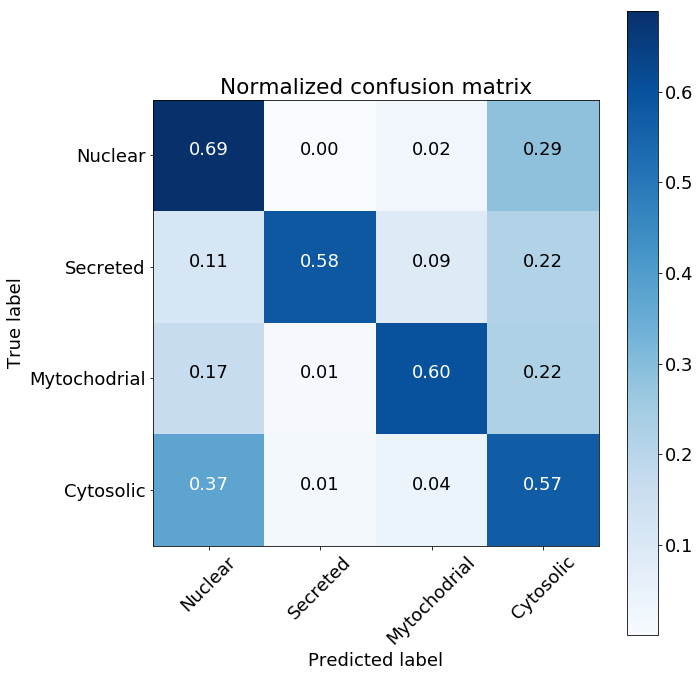

In [19]:
forest_accuracy = accuracy_score(y_val, y_pred_forest)
print("Accuracy score for Random Forest: {}".format(forest_accuracy))
forest_f1 = f1_score(y_val, y_pred_forest, average='weighted')
print("F1 score for Random Forest: {}".format(forest_f1))
print("Confusion matrix for Random Forest: ")
print(confusion_matrix(y_val, y_pred_forest))

if cross_val:
    forest_cv_scores = cross_val_score(forest, features_array, labels_array, cv=cv_k)
    print(forest_cv_scores)

    print("Accuracy: {} (+/- {})".format(forest_cv_scores.mean(), (forest_cv_scores.std() * 2)))


# Compute confusion matrix
forest_cnf_matrix = confusion_matrix(y_val, y_pred_forest)
np.set_printoptions(precision=2)

# plt.rc('font', size=15)   
# Plot non-normalized confusion matrix
# plt.figure(figsize=(10,10))
# plot_confusion_matrix(forest_cnf_matrix, classes=class_names,
#                       title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure(figsize=(10,10))
plt.rc('font', size=18)
plot_confusion_matrix(forest_cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

## Adaboost

Accuracy score for Adaboost: 0.6270350271336951
F1 score for Adaboost: 0.6275314134536771
Confusion matrix for Random Forest: 
[[585   0  24 231]
 [ 13  68  10  24]
 [ 53   1 205  72]
 [277   8  43 413]]
[0.64 0.62 0.66 0.58 0.59 0.6  0.62 0.6 ]
Accuracy: 0.6145495305376828 (+/- 0.05026082790366124)
Normalized confusion matrix


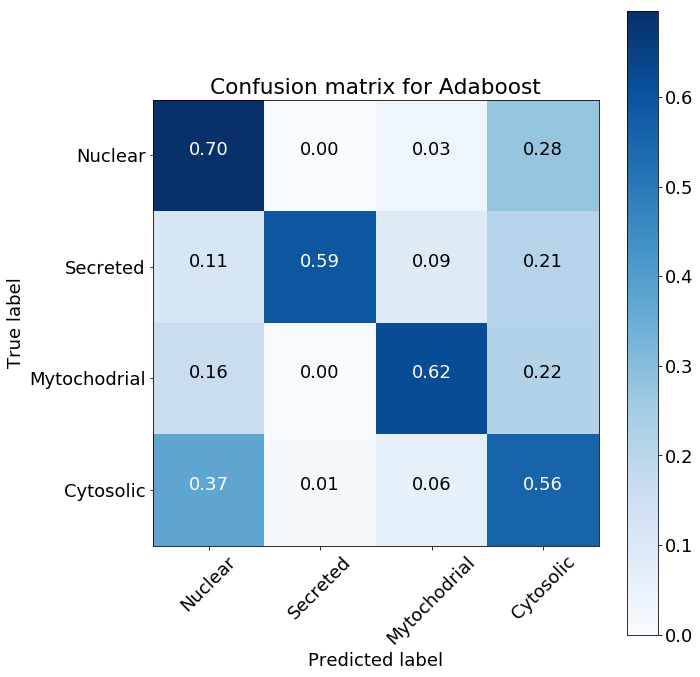

In [20]:
ada_accuracy = accuracy_score(y_val, y_pred_ada)
print("Accuracy score for Adaboost: {}".format(ada_accuracy))
ada_f1 = f1_score(y_val, y_pred_ada, average='weighted')
print("F1 score for Adaboost: {}".format(ada_f1))
print("Confusion matrix for Random Forest: ")
print(confusion_matrix(y_val, y_pred_ada))

if cross_val:
    ada_cv_scores = cross_val_score(attaboy, features_array, labels_array, cv=cv_k)
    print(ada_cv_scores)

    print("Accuracy: {} (+/- {})".format(ada_cv_scores.mean(), (ada_cv_scores.std() * 2)))

# Compute confusion matrix
ada_cnf_matrix = confusion_matrix(y_val, y_pred_ada)
np.set_printoptions(precision=2)

plt.rc('font', size=18)   
# Plot non-normalized confusion matrix
# plt.figure(figsize=(10,10))
# plot_confusion_matrix(ada_cnf_matrix, classes=class_names,
#                       title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure(figsize=(10,10))
plot_confusion_matrix(ada_cnf_matrix, classes=class_names, normalize=True,
                      title='Confusion matrix for Adaboost')

plt.show()

# ROC Curves

In [21]:
X, y = features_array, labels_array

# Binarize the output
y = label_binarize(y, classes=[0, 1, 2, 3])
n_classes = y.shape[1]

# # shuffle and split training and test sets
X_train_roc, X_test_roc, y_train_roc, y_test_roc = train_test_split(X, y, test_size=.25,
                                                    random_state=0)

In [22]:
# Learn to predict each class against the other
classifier = OneVsRestClassifier(attaboy)
y_score = classifier.fit(X_train_roc, y_train_roc).decision_function(X_test_roc)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_roc[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_roc.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

#Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

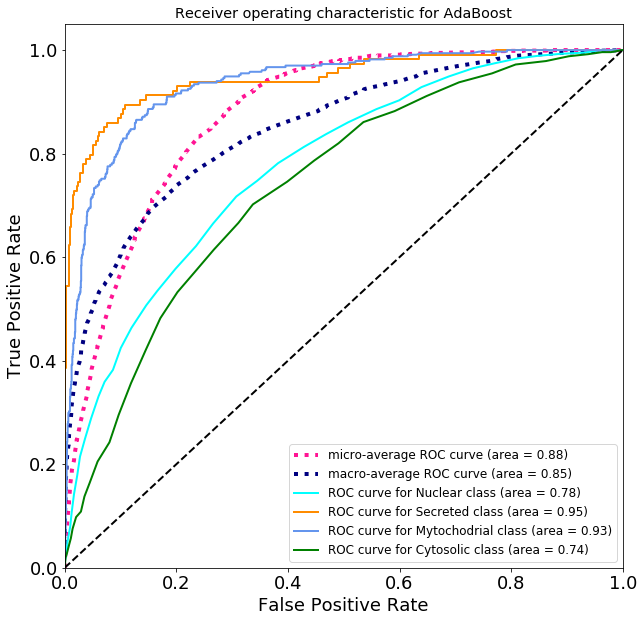

In [23]:
# Plot all ROC curves
plt.figure(figsize=(10,10))
lw = 2
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve for {0} class (area = {1:0.2f})'
             ''.format(class_names[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.rc('font', size=12)  
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for AdaBoost')
plt.legend(loc="lower right")
plt.show()

# ROC curve for LR

In [24]:
# Learn to predict each class against the other
classifier = OneVsRestClassifier(logreg)
y_score = classifier.fit(X_train_roc, y_train_roc).decision_function(X_test_roc)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_roc[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_roc.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

#Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

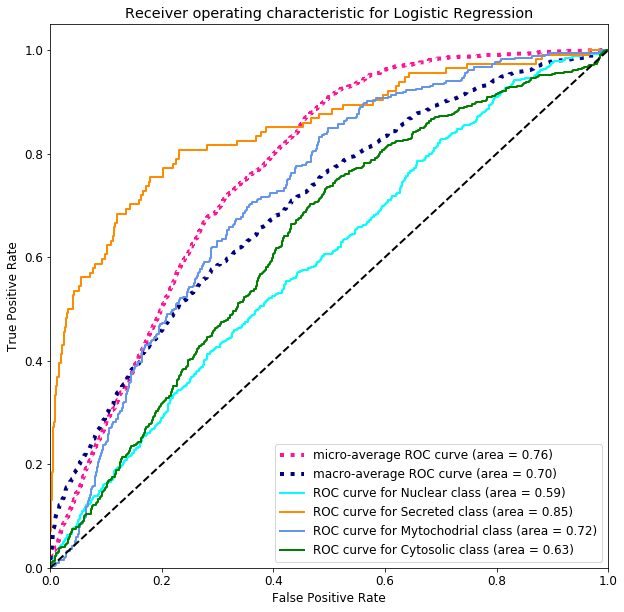

In [25]:
# Plot all ROC curves
plt.figure(figsize=(10,10))
lw = 2
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve for {0} class (area = {1:0.2f})'
             ''.format(class_names[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.rc('font', size=12)  
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for Logistic Regression')
plt.legend(loc="lower right")
plt.show()

## Ensemble

In [26]:
eclf_accuracy = accuracy_score(y_val, y_pred_eclf)
print("Accuracy score for Ensemble: {}".format(eclf_accuracy))
eclf_f1 = f1_score(y_val, y_pred_eclf, average='weighted')
print("F1 score for Ensemble: {}".format(eclf_f1))
print("Confusion matrix for Ensemble: ")
print(confusion_matrix(y_val, y_pred_eclf))

# Compute confusion matrix
eclf_cnf_matrix = confusion_matrix(y_val, y_pred_eclf)
np.set_printoptions(precision=2)

plt.rc('font', size=20)   
# Plot non-normalized confusion matrix
# plt.figure(figsize=(10,10))
# plot_confusion_matrix(ada_cnf_matrix, classes=class_names,
#                       title='Confusion matrix, without normalization')

# # Plot normalized confusion matrix
# plt.figure(figsize=(10,10))
# plot_confusion_matrix(ada_cnf_matrix, classes=class_names, normalize=True,
#                       title='Normalized confusion matrix')

# plt.show()

if cross_val:
    eclf_cv_scores = cross_val_score(eclf, features_array, labels_array, cv=4)
    print(eclf_cv_scores)

    print("Accuracy: {} (+/- {})".format(eclf_cv_scores.mean(), (eclf_cv_scores.std() * 2)))

Accuracy score for Ensemble: 0.6008880118401578
F1 score for Ensemble: 0.5970119999799417
Confusion matrix for Ensemble: 
[[617   1   8 214]
 [ 31  55   1  28]
 [ 99   1 140  91]
 [314   5  16 406]]


/Users/daniel/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/daniel/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/daniel/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0.6  0.59 0.58 0.58]
Accuracy: 0.58891943882504 (+/- 0.020175507566152346)


/Users/daniel/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


# Predictions for test set

In [27]:
test_sequences = []
test_lengths = []

file_names = next(os.walk(DATA_DIR))[2]
print(file_names)


alphabet = ExtendedIUPACProtein()

_cols = ['seq', 'seq_length', "molecular_weight", 'isoelectric_point', 'aromaticity', 'instability']
_ids = []
_sequences = []
_location = []
_location_name = []
_lengths = []
_mol_weight = []
_aromaticity = []
_instability = []
_isoelectric_point = []
_aa_percents = []
_first_50_percents = []
_last_50_percents = []
_structure = []

file = "test.rtf"
for seq_record in SeqIO.parse(os.path.join(DATA_DIR, file), "fasta", alphabet=ExtendedIUPACProtein()):
    if 'X' in str(seq_record.seq) or 'U' in str(seq_record.seq):
        pass
    else:
        _ids.append(str(seq_record.id).translate({ord(c): None for c in '\!@#$/{}'}))
        _clean_numbers = []
        clean_sequence = str(seq_record.seq).translate({ord(c): None for c in '\!@#$/{}'})
        for i in clean_sequence:
            num = ord(i) - 64
            _clean_numbers.append(num)
        _clean_numbers.extend(np.zeros((7393 - len(_clean_numbers))))
        _sequences.append(clean_sequence)


        _lengths.append(len(clean_sequence))

        _analysed_seq = ProteinAnalysis(clean_sequence)
        _mol_weight.append(_analysed_seq.molecular_weight())
        _aromaticity.append(_analysed_seq.aromaticity())
        _instability.append(_analysed_seq.instability_index())
        _isoelectric_point.append(_analysed_seq.isoelectric_point())

        _aa_percents.append(_analysed_seq.get_amino_acids_percent())

        _first_50_seq = ProteinAnalysis(clean_sequence[0:49])
        _first_50_percents.append(_first_50_seq.get_amino_acids_percent())

        _last_50_seq = ProteinAnalysis(clean_sequence[-50:])
        _last_50_percents.append(_last_50_seq.get_amino_acids_percent())
        
        _structure.append(_analysed_seq.secondary_structure_fraction())

['test.rtf', 'Nuclear.rtf', 'Secreted.rtf', 'Mytochodrial.rtf', 'Cytosolic.rtf']


In [28]:
_aa_percents_DF = pd.DataFrame.from_dict(_aa_percents)
_first_50_df = pd.DataFrame.from_dict(_first_50_percents)
_last_50_df = pd.DataFrame.from_dict(_last_50_percents)
_structure_df = pd.DataFrame(_structure)
_parsed_df = pd.DataFrame(list(zip(_sequences, _lengths, _mol_weight, _isoelectric_point, _aromaticity, _instability)), columns=_cols)            
_parsed_df = pd.concat([_parsed_df, _first_50_df, _aa_percents_DF, _last_50_df, _structure_df], axis=1)


In [29]:
test_features_array = _parsed_df.drop(columns='seq').values

In [30]:
predictions = [class_names[i][:4] for i in attaboy.predict(test_features_array)]
all_probabilities = attaboy.predict_proba(test_features_array)
confidence = np.around(np.amax(all_probabilities, axis=1)*100,4)

In [31]:
submission = pd.DataFrame(list(zip(_ids, predictions, confidence)), columns=['ID', 'class', 'confidence'])

In [32]:
submission

,ID,class,confidence
0,SEQ677,Cyto,52.0
1,SEQ231,Cyto,46.0
2,SEQ871,Nucl,40.0
3,SEQ388,Nucl,42.0
4,SEQ122,Nucl,76.0
5,SEQ758,Nucl,50.0
6,SEQ333,Cyto,48.0
7,SEQ937,Cyto,68.0
8,SEQ351,Cyto,58.0
9,SEQ202,Myto,70.0
